In [120]:
import pyspark
from pyspark import BasicProfiler
# sc = pyspark.SparkContext(pyspark.SparkConf().setMaster("local[12]"))
import numpy as np
import time
# spark tools for making operations readable
class NamedLambda(object):
    """
    allows the use of named anonymous functions for arbitrary calculations
    """
    def __init__(self, code_name, code_block, **add_args):
        self.code_name = code_name
        self.code_block = code_block
        self.add_args = add_args
        self.__name__ = code_name
    def __call__(self, *cur_objs, **kwargs):
        return self.code_block(*cur_objs, **kwargs, **self.add_args)
    def __repr__(self):
        return self.code_name
    def __str__(self):
        return self.__repr__()
    
class FieldSelector(object):
    """
    allows the use of named anonymous functions for selecting fields (makes dag's more readable)
    """
    def __init__(self, field_name):
        self.field_name = field_name
        self.__name__ = "Select Field: {}".format(self.field_name)
    def __call__(self, cur_obj):
        try:
            return cur_obj[self.field_name]
        except:
            return cur_obj._asdict()[self.field_name]
    def __repr__(self):
        return __name__
    def __str__(self):
        return self.__repr__()

In [96]:
from collections import namedtuple
url_id = namedtuple('url', ['url'])
src_tile_id = namedtuple('source_tile_position', ['img_id', 'z', 'x', 'y', 'type'])
dest_tile_id = namedtuple('target_tile_position', ['img_id', 'z', 'x', 'y', 'type'])
tile_item = namedtuple('tile_data', ['request' ,'target_tile_id', 'source_tile_id', 'source_tile_data', 'out_tile_data'])

IM_W, IM_H = 60000, 60000
IM_W, IM_H = 600, 600
TILE_W, TILE_H = 2000, 2000
TILE_W, TILE_H = 20, 20

TILE_W, TILE_H = 60, 60
#TILE_W, TILE_H = 200, 200
TILES_PER_IMAGE = int(IM_W / TILE_W * IM_H / TILE_H)

DELAY_SCALE = 0

def stack(arr_list, axis = 0): 
    """
    since numpy 1.8.2 does not have the stack command
    """
    assert axis == 0, "Only works for axis 0"
    return np.vstack(map(lambda x: np.expand_dims(x,0), arr_list))

def get_output_tiles(req_str):
    return [(req_str,src_tile_id(req_str, -1, x, y,"out")) for x in np.arange(0, IM_W, TILE_W)
            for y in np.arange(0, IM_H, TILE_H)]

def calc_input_tiles(o_tile, n_size = 1, delay = 0):
    """
    A simple 3x3 neighborhood with a delay second delay
    """
    time.sleep(DELAY_SCALE*delay)
    return [(o_tile, dest_tile_id(
                img_id = o_tile.img_id,
                z = o_tile.z,
                type = "in",
                x=ix, 
                y=iy)) 
            for ix in np.arange(o_tile.x-n_size*TILE_W,o_tile.x+(n_size+1)*TILE_W, TILE_W) if ix>0
            for iy in np.arange(o_tile.y-n_size*TILE_H,o_tile.y+(n_size+1)*TILE_H, TILE_H) if iy>0]

def pull_input_tile(i_tile, delay = 2.5):
    """
    Generates a random, but unique 8 bit input tile given the source tile id i_tile
    """
    assert i_tile.type.find("in")==0
    time.sleep(DELAY_SCALE*delay)
    np.random.seed(i_tile.__hash__() % 4294967295) # should make process deterministic
    return np.random.uniform(-127, 127, size = (TILE_W, TILE_H)).astype(np.int8)

RECON_TIME = 1.0
def partial_reconstruction(src_tile, targ_tile, tile_data, delay = RECON_TIME):
    time.sleep(DELAY_SCALE*delay)
    out_data = tile_data.copy()
    out_data[out_data>20] = 0
    return out_data

def combine_reconstructions(many_slices):
    """
    Bring a number of partial reconstructions together
    """
    return np.sum(stack(many_slices,0),0)

def full_reconstruction(src_tiles, pr_delay = RECON_TIME/2):
    """
    Run the full reconstruction as one step
    """
    out_images = [partial_reconstruction(src.source_tile_id, src.target_tile_id, src.source_tile_data, delay = pr_delay) for src in src_tiles]
    return combine_reconstructions(out_images)
    
    

In [97]:
# intermediate spark functions
def ti_full_reconstruction(x):
    k, src_tiles = x
    return k, full_reconstruction(src_tiles)    

def grp_tile_read(x):
        src_tile_id, tile_items = x
        tile_data = pull_input_tile(src_tile_id)
        return [i._replace(source_tile_data = tile_data) for i in tile_items]

def ti_partial_reconstruction(in_tile_item):
    return in_tile_item._replace(
        out_tile_data = partial_reconstruction(in_tile_item.source_tile_id,
                                               in_tile_item.target_tile_id,
                                               in_tile_item.source_tile_data),
        source_tile_data = None # throw out the old data
        )

def ti_partial_collect(x):
    k, in_tile_items = x # don't need the key
    assert len(in_tile_items)>0, "Cannot provide empty partial collecton set"
    iti_list = list(in_tile_items)
    all_part_recon = map(lambda x: x.out_tile_data, in_tile_items)
    
    return (k, combine_reconstructions(all_part_recon))

In [98]:
def _build_input(in_sc, reqs):
    req_rdd = in_sc.parallelize(reqs)
    out_tile_rdd = req_rdd.flatMap(get_output_tiles).repartition(100)
    shuffle_tile_fields = NamedLambda("Shuffle Tile Fields", lambda x: tile_item(x[0], x[1][0], x[1][1], None, None))
    all_tile_rdd = out_tile_rdd.flatMapValues(calc_input_tiles).map(shuffle_tile_fields)
    return all_tile_rdd
def build_naive_pipe(in_sc, reqs):
    all_tile_rdd = _build_input(in_sc, reqs)
    # parallel reading of the data
    read_fcn = NamedLambda("pull_input_tile", lambda i: i._replace(source_tile_data = pull_input_tile(i.source_tile_id)))
    all_tile_rdd_data = all_tile_rdd.map(read_fcn)
    # parallel combining of the tiles
    recon_tiles_rdd = all_tile_rdd_data.groupBy(FieldSelector('target_tile_id')).map(ti_full_reconstruction)
    return recon_tiles_rdd

def build_grpread_pipe(in_sc, reqs):
    all_tile_rdd = _build_input(in_sc, reqs)
    single_read_tiles_rdd = all_tile_rdd.groupBy(FieldSelector('source_tile_id')).flatMap(grp_tile_read)
    gr_recon_tiles_rdd = single_read_tiles_rdd.groupBy(FieldSelector('target_tile_id')).map(ti_full_reconstruction)
    return gr_recon_tiles_rdd

def build_partialrecon_pipe(in_sc, reqs):
    all_tile_rdd = _build_input(in_sc, reqs)
    # group together all files by source tile and then read that source tile and put in into every item
    single_read_tiles_rdd = all_tile_rdd.groupBy(FieldSelector('source_tile_id')).flatMap(grp_tile_read)
    # run a partial reconstruction on every item
    partial_recon_tiles_rdd = single_read_tiles_rdd.map(ti_partial_reconstruction)
    # combine all the partial reconstructions to create the final reconstruction
    full_recon_tiles_rdd = partial_recon_tiles_rdd.groupBy(FieldSelector('target_tile_id')).map(ti_partial_collect)
    return full_recon_tiles_rdd
test_reqs = list(map(url_id, ['test1', 'test2', 'test3']))

In [99]:
print(_build_input(sc, ['test1', 'test2']).first())

tile_data(request='test2', target_tile_id=source_tile_position(img_id='test2', z=-1, x=0, y=0, type='out'), source_tile_id=target_tile_position(img_id='test2', z=-1, x=60, y=60, type='in'), source_tile_data=None, out_tile_data=None)


# Simple / Naive Approach
The Simple Naive Approach does not attempt to group together operations reading the same input times and just runs each independently

In [88]:
recon_tiles_rdd = build_naive_pipe(sc, ['test1', 'test2'])

In [89]:
%%time
all_shapes = recon_tiles_rdd.mapValues(lambda x: x.shape).collect()
print('All Results', len(all_shapes))

All Results 200
CPU times: user 26.8 ms, sys: 9.58 ms, total: 36.4 ms
Wall time: 1.79 s


# Grouped Read Approach


In [90]:
gr_recon_tiles_rdd = build_grpread_pipe(sc, ['test1', 'test2'])

In [91]:
%%time
all_shapes = gr_recon_tiles_rdd.mapValues(lambda x: x.shape).collect()
print('All Results', len(all_shapes))

All Results 200
CPU times: user 37 ms, sys: 13.5 ms, total: 50.4 ms
Wall time: 3.21 s


# Second Approach
Partial Results to Final Results

In [92]:
full_recon_tiles_rdd = build_partialrecon_pipe(sc, ['test1', 'test2'])

In [93]:
%%time
all_shapes = full_recon_tiles_rdd.mapValues(lambda x: x.shape).collect()
print('All Results',len(all_shapes))

All Results 200
CPU times: user 36.1 ms, sys: 13.1 ms, total: 49.1 ms
Wall time: 2.88 s


In [94]:
# check every element to ensure they are identical
for i, (x,y) in enumerate(zip(full_recon_tiles_rdd.first()[1].flatten(), 
                              recon_tiles_rdd.first()[1].flatten())):
    assert x == y, "Index {} doesnt match ({} != {})".format(i, x, y)

# Compressing Tiles and Output
Here we compress the tiles and then write the output

In [108]:
from io import BytesIO
def compress_tile(in_tile):
    out_stream = BytesIO()
    np.savez_compressed(out_stream, out_tile = in_tile)
    out_stream.seek(0) # restart at beginning
    return out_stream

t_image = np.random.uniform(0, 255, size = (2000, 2000, 4)).astype(np.int16)

ImportError: No module named 'cpickle'

In [109]:
%%time
ios = compress_tile(t_image)

CPU times: user 6.25 s, sys: 246 ms, total: 6.49 s
Wall time: 6.86 s


In [130]:
from io import BytesIO
def compress_tile(in_tile):
    out_stream = BytesIO()
    np.savez_compressed(out_stream, out_tile = in_tile)
    out_stream.seek(0) # restart at beginning
    return b''.join(out_stream.readlines())

import tempfile
def write_tiles(kvarg):
    img_info, tile_list = kvarg
    out_data = b''
    out_file = tempfile.NamedTemporaryFile(suffix = 'jp2', prefix = str(img_info))
    for tile_info, tile_data in tile_list:
        out_file.write(tile_data)
    
    return (img_info,out_file.name)
def build_full_pipe(in_sc, reqs, read_pipe = build_grpread_pipe):
    full_recon_tiles_rdd = build_grpread_pipe(in_sc, reqs)
    all_image_rdd = full_recon_tiles_rdd.mapValues(compress_tile).groupBy(NamedLambda("Select Field : img_id",lambda x: x[0].img_id))
    return all_image_rdd.map(write_tiles)

def build_parallelio_pipe(in_sc, reqs, read_pipe = build_grpread_pipe):
    full_recon_tiles_rdd = build_grpread_pipe(in_sc, reqs)
    all_image_rdd = full_recon_tiles_rdd.mapValues(compress_tile).groupBy(NamedLambda("Select Field : img_id",lambda x: x[0].img_id))
    return all_image_rdd.saveAsPickleFile('test_output_pkl')

In [131]:
full_pipe = build_full_pipe(sc, test_reqs)

In [132]:
full_pipe.first()

(url(url='test3'),
 "/var/folders/87/qdzwp8795sj37r777qjqyybm0000gn/T/url(url='test3')jbkiejxijp2")

In [133]:
%%time
all_image_rdd.saveAsPickleFile('test_output_pkl')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 21 µs


# Light Keys and Heavy Values
## DataFrame vs RDD

In [34]:
# Make a cached performant RDD to start with
x_to_tile = lambda x: tile_id("",0,int(x),int(x),"in")
keys_rdd = sc.parallelize(range(101),20).map(x_to_tile).cache()
_ = keys_rdd.collect()

# Using Standard RDDs
Using a standard RDD the entire data has to be loaded / processed in order to check the x value.

In [35]:
kimg_rdd = keys_rdd.map(lambda x: (x, pull_input_tile(x)))

In [14]:
%%time
kimg_rdd.filter(lambda kv_data: kv_data[0].x>99).collect()

CPU times: user 17.6 ms, sys: 12.5 ms, total: 30.1 ms
Wall time: 1min 8s


[(tile_id(img_id='', z=0, x=100, y=100, type='in'),
  array([[-111,   57,   87, ...,    3,   42,  -43],
         [-105,    4,  -40, ...,   38,   74,  -34],
         [  40,  -65,  -50, ...,   55,  -59, -113],
         ..., 
         [ -25,   27,  123, ...,  -78,   83,   78],
         [ -16,  -78,  -50, ..., -111,  -73,  123],
         [ -82,  -30,  -46, ...,  102,   -4,  104]], dtype=int8))]

# Using DataFrames
Using DataFrames the exact same query can be conducted without looking at the image column at all. Here the image column is only examined at the very end.

In [15]:
from pyspark.sql import functions as F
import pyspark.sql.types as sq_types
kmeta_df = sqlContext.createDataFrame(keys_rdd.map(lambda x: x._asdict()))
# applying python functions to DataFrames is more difficult and requires using typed UDFs
twod_arr_type = sq_types.ArrayType(sq_types.ArrayType(sq_types.IntegerType()))
# the pull_input_tile function is wrapped into a udf to it can be applied to create the new image column
# numpy data is not directly supported and typed arrays must be used instead therefor we run the .tolist command
pull_tile_udf = F.udf(lambda x: pull_input_tile(x_to_tile(x)).tolist(), returnType = twod_arr_type)
kimg_df = kmeta_df.withColumn('Image', pull_tile_udf(kmeta_df['x']))

In [16]:
%%time
s_query = kimg_df.where(kimg_df['x']>99)
s_query.show()

+------+----+---+---+---+--------------------+
|img_id|type|  x|  y|  z|               Image|
+------+----+---+---+---+--------------------+
|      |  in|100|100|  0|[WrappedArray(-11...|
+------+----+---+---+---+--------------------+

CPU times: user 4.45 ms, sys: 2.71 ms, total: 7.16 ms
Wall time: 6.76 s


In [17]:
%%time
kimg_df.where(kimg_df['x']==27).show()

+------+----+---+---+---+--------------------+
|img_id|type|  x|  y|  z|               Image|
+------+----+---+---+---+--------------------+
|      |  in| 27| 27|  0|[WrappedArray(110...|
+------+----+---+---+---+--------------------+

CPU times: user 4.01 ms, sys: 2.34 ms, total: 6.35 ms
Wall time: 4.87 s


In [18]:
# show the array to make sure it matches
iv_arr = np.array(s_query.first().Image)
iv_arr

array([[-111,   57,   87, ...,    3,   42,  -43],
       [-105,    4,  -40, ...,   38,   74,  -34],
       [  40,  -65,  -50, ...,   55,  -59, -113],
       ..., 
       [ -25,   27,  123, ...,  -78,   83,   78],
       [ -16,  -78,  -50, ..., -111,  -73,  123],
       [ -82,  -30,  -46, ...,  102,   -4,  104]])

In [19]:
# test cartesian product later kmeta_df.join(s_query, on = ["x", "y"], how = 'inner').show()

In [20]:
s_query.explain()

== Physical Plan ==
*Project [img_id#0, type#1, x#2L, y#3L, z#4L, pythonUDF0#39 AS Image#11]
+- BatchEvalPython [<lambda>(x#2L)], [img_id#0, type#1, x#2L, y#3L, z#4L, pythonUDF0#39]
   +- *Filter (isnotnull(x#2L) && (x#2L > 99))
      +- Scan ExistingRDD[img_id#0,type#1,x#2L,y#3L,z#4L]


In [21]:
pt_2d_type = sq_types.StructType(fields = [sq_types.StructField("_1", sq_types.IntegerType()), 
                     sq_types.StructField("_2", sq_types.IntegerType())])
brightest_point_udf = F.udf(lambda x: np.unravel_index(np.argmax(x), dims = np.shape(x)), returnType = pt_2d_type)
mean_point_udf = F.udf(lambda x: float(np.mean(x)), returnType = sq_types.DoubleType())
kimg_max_df = kimg_df.withColumn('MeanPoint', mean_point_udf(kimg_df['Image']))

In [23]:
%%time
four_img_query = kimg_max_df.where(kimg_max_df['x']>88).where(kimg_max_df['y']<92)
four_img_query.show()

+------+----+---+---+---+--------------------+-----------+
|img_id|type|  x|  y|  z|               Image|  MeanPoint|
+------+----+---+---+---+--------------------+-----------+
|      |  in| 89| 89|  0|[WrappedArray(-12...|-0.01192325|
|      |  in| 90| 90|  0|[WrappedArray(80,...| 0.03578475|
|      |  in| 91| 91|  0|[WrappedArray(23,...|  -0.047191|
+------+----+---+---+---+--------------------+-----------+

CPU times: user 5.82 ms, sys: 3.92 ms, total: 9.74 ms
Wall time: 16.9 s


In [24]:
four_img_query.explain()

== Physical Plan ==
*Project [img_id#0, type#1, x#2L, y#3L, z#4L, pythonUDF0#62 AS Image#11, pythonUDF1#63 AS MeanPoint#40]
+- BatchEvalPython [<lambda>(x#2L), <lambda>(<lambda>(x#2L))], [img_id#0, type#1, x#2L, y#3L, z#4L, pythonUDF0#62, pythonUDF1#63]
   +- *Filter (((isnotnull(x#2L) && (x#2L > 88)) && isnotnull(y#3L)) && (y#3L < 92))
      +- Scan ExistingRDD[img_id#0,type#1,x#2L,y#3L,z#4L]


In [9]:
?all_tile_rdd.prev

In [11]:
all_tile_rdd.prev.first()

('test2',
 (tile_id(img_id='test2', z=-1, x=0, y=0, type='out'),
  tile_id(img_id='test2', z=-1, x=2000, y=2000, type='in')))

In [12]:
all_tile_rdd.first()

tile_item(request='test2', target_tile_id=tile_id(img_id='test2', z=-1, x=0, y=0, type='out'), source_tile_id=tile_id(img_id='test2', z=-1, x=2000, y=2000, type='in'), source_tile_data=None, out_tile_data=None)

In [13]:
all_tile_rdd.func

<function pyspark.rdd.PipelinedRDD.__init__.<locals>.pipeline_func>

In [14]:
import inspect

In [15]:
inspect.getsourcelines(all_tile_rdd.func)

(['            def pipeline_func(split, iterator):\n',
  '                return func(split, prev_func(split, iterator))\n'],
 2370)

In [63]:
import pydot
def show_dag(cur_rdd, o_file):
    from IPython.display import SVG
    b_dot = trace_dag(cur_rdd)
    b_dot.write_svg(o_file)
    return SVG(o_file)
def trace_dag(cur_rdd):
    dot_graph = pydot.Dot(graph_type='digraph')
    dot_graph.set('rankdir', 'TB')
    dot_graph.set('concentrate', False)
    dot_graph.set_node_defaults(shape='record')
    add_rdd_node(dot_graph, cur_rdd)
    return dot_graph

def add_rdd_node(dot_graph, cur_rdd):
    """
    Recursive function to add all RDDs to a DAG given a starting node
    """
    def make_node(name, label):
        cur_node = pydot.Node(name)
        cur_node.set_label(label)
        dot_graph.add_node(cur_node)
        return cur_node
    def make_link(a_node, b_node, label = None, width = 1, style='dashed'):
        cur_edge = pydot.Edge(a_node,b_node)
        cur_edge.set_penwidth(width)
        cur_edge.set_style(style)
        if label is not None: cur_edge.set_label(label)
        dot_graph.add_edge(cur_edge)
        return cur_edge
    try:
        op_name = cur_rdd.command_args[0]
        cmd_name = cur_rdd.command_args[1]
        func_obj = cur_rdd.command_args[1].get('apply_func',lambda x: x)
        print(op_name, 'type',cur_rdd.type, func_obj, '->', func_name)
    except:
        print("must be a real rdd")
        op_name = "MapPartitions"
        func_obj = cur_rdd.__dict__.get('func',lambda x: x)
    
    func_name = 'Custom' if func_obj.__name__.find('lambda')>=0 else func_obj.__name__
    func_name = 'Custom' if func_name.find('pipeline_func')>=0 else func_name
    if op_name == 'parallelize': func_name = 'parallelize : {}'.format(func_name)
    
    label = '%s\n|{type:|count:}|{{%s}|{%s}}' % (func_name, LocalRDD.typeInfo(cur_rdd.first()), cur_rdd.count())
    c_node = make_node(cur_rdd.id(), label)
    if type(cur_rdd) is list:
        parent_nodes = []
    else:
        parent_nodes = cur_rdd.__dict__.get('prev',[])
        if type(parent_nodes) is not list: parent_nodes = [parent_nodes]
    
    for inode in parent_nodes:
        next_node, next_op_name = add_rdd_node(dot_graph, inode)
        l_count = 3 if op_name.find('flat')>=0 else 1
        for l_id in range(l_count):
            make_link(next_node, c_node, label = op_name if l_id is 0 else None)
    return c_node, op_name
    

In [60]:
cdag = trace_dag(all_tile_rdd)

must be a real rdd
must be a real rdd
must be a real rdd


In [62]:
cdag.obj_dict['nodes']

{<bound method RDD.id of MapPartitionsRDD[5] at repartition at NativeMethodAccessorImpl.java:-2>: [{'attributes': {'label': 'Custom\n|{type:|count:}|{{(string, tile_id)}|{18}}'},
   'name': <bound method RDD.id of MapPartitionsRDD[5] at repartition at NativeMethodAccessorImpl.java:-2>,
   'parent_graph': <pydot.Dot at 0x10a2b1cf8>,
   'parent_node_list': None,
   'port': None,
   'sequence': 4,
   'type': 'node'}],
 'node': [{'attributes': {'shape': 'record'},
   'name': 'node',
   'parent_graph': <pydot.Dot at 0x10a2b1cf8>,
   'parent_node_list': None,
   'port': None,
   'sequence': 1,
   'type': 'node'}],
 <bound method PipelinedRDD.id of PythonRDD[80] at RDD at PythonRDD.scala:48>: [{'attributes': {'label': 'Custom\n|{type:|count:}|{{tile_item}|{72}}'},
   'name': <bound method PipelinedRDD.id of PythonRDD[80] at RDD at PythonRDD.scala:48>,
   'parent_graph': <pydot.Dot at 0x10a2b1cf8>,
   'parent_node_list': None,
   'port': None,
   'sequence': 2,
   'type': 'node'}],
 <bound met

must be a real rdd
must be a real rdd
must be a real rdd


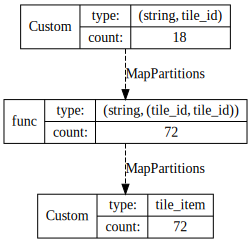

In [64]:

show_dag(all_tile_rdd, 'pyspark_rdd.svg')

In [22]:
class LocalRDD(object):
    def __init__(self, items, parent, command, code = '', **args):
        self.items = list(items)
        self.prev = parent
        self.command_args = (command, args)
        self.code = code
    
    def first(self):
        return self.items[0]
    
    def collect(self):
        return self.items
    
    def count(self):
        return len(self.items)
    
    def _transform(self, op_name, in_func, lapply_func, **args):
        """
        Args:
            in_func is the function the user supplied
            lapply_func is the function to actually apply
        """
        try:
            trans_func_code = inspect.getsourcelines(in_func)
        except:
            trans_func_code = ''
        new_list = lapply_func(self.items)
        return LocalRDD(new_list, [self], op_name, apply_func = in_func, code = trans_func_code, **args)
        
    def map(self, apply_func):
        return self._transform('map', apply_func, 
                               lapply_func =  lambda x_list: [apply_func(x) for x in x_list])
    
    def mapValues(self, apply_func):
        return self._transform('mapValues', apply_func, 
                               lapply_func = lambda x_list: [(k, apply_func(v)) for (k,v) in x_list])
    
    def flatMap(self, apply_func):
        return self._transform('flatMap', apply_func, 
                               lapply_func = lambda x_list: cflatten([apply_func(x) for x in x_list]))
    
    def flatMapValues(self, apply_func):
        return self._transform('flatMapValues', apply_func, 
                               lapply_func = lambda x_list: cflatten([[(k, y) for y in apply_func(v)] for (k,v) in x_list]))
    
    def groupBy(self, apply_func):
        def gb_func(x_list):
            o_dict = defaultdict(list)
            for i in x_list:
                o_dict[apply_func(i)]+= [i]
            return list(o_dict.items())
        return self._transform('groupBy', apply_func, 
                               lapply_func = gb_func)
    
    
    def saveAsPickleFile(self, filename):
        return self._transform('saveAsPickleFile', pickle.dump, 
                               lapply_func =  lambda x_list: [(x, filename) for x in x_list])
    def repartition(self, *args):
        return self
                               
    
    # collection of informational functions
    @staticmethod
    def typeInfo(obj):
        if type(obj) is tuple:
            return '({})'.format(', '.join(map(LocalRDD.typeInfo,obj)))
        elif type(obj) is list:
            return 'list({})'.format(LocalRDD.typeInfo(obj[0]))
        else:
            ctype_name = type(obj).__name__
            if ctype_name == 'ndarray': return '{}{}'.format(ctype_name,obj.shape)
            elif ctype_name == 'str': return 'string'
            else: return ctype_name
    
    @property
    def type(self):
        return LocalRDD.typeInfo(self.first())
    
    @property
    def key_type(self):
        return LocalRDD.typeInfo(self.items[0][0])
    
    @property
    def value_type(self):
        return LocalRDD.typeInfo(self.items[0][1])
    
    @property
    def id(self):
        return (str(self.items), tuple(self.parent), str(self.command_args)).__hash__()
        

class LocalSparkContext(object):
    def __init__(self):
        pass
    def parallelize(self, in_list):
        return LocalRDD(in_list, [], 'parallelize', in_list = in_list)

class NamedLambda(object):
    """
    allows the use of named anonymous functions for arbitrary calculations
    """
    def __init__(self, code_name, code_block, **add_args):
        self.code_name = code_name
        self.code_block = code_block
        self.add_args = add_args
    def __call__(self, cur_obj):
        return self.code_block(cur_obj, **self.add_args)
    def __repr__(self):
        return self.code_name
    
    @property
    def __name__(self):
        return self.__repr__()
class FieldSelector(object):
    """
    allows the use of named anonymous functions for selecting fields (makes dag's more readable)
    """
    def __init__(self, field_name):
        self.field_name = field_name
    def __call__(self, cur_obj):
        try:
            return cur_obj[self.field_name]
        except:
            return cur_obj._asdict()[self.field_name]
    def __repr__(self):
        return "Select Field: {}".format(self.field_name)
    
    @property
    def __name__(self):
        return self.__repr__()